<a href="https://colab.research.google.com/github/shunte88/MiT_DSD/blob/main/Module19_CNN_Optimizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import numpy as np
from numpy import random

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
# removed in 2023
#from keras.utils import np_utils
from keras import utils as np_utils

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, Callback
from keras import regularizers
from keras.optimizers import Adam
####!pip freeze

This is a dataset of handwritten grayscale images where each image is 28x28 pixels in .CSV format. Evaluating digits is much simpler than other image recognition problems so this is a perfect dataset for evaluating different models.

###### Place the train.csv file in your google drive under the xpro path

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
df = pd.read_csv("sample_data/train.csv")
# test_df = pd.read_csv("/content/drive/MyDrive/XPro/test.csv")

In [3]:
df.sample(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
35813,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Write a method to visualize the images:

In [4]:


def display_images(X, y=[], rows=5, columns=5, cmap="gray"):
    """ Display images and labels
    """
    fig, ax = plt.subplots(rows,columns, figsize=(6,6))
    for row in range(rows):
        for column in range(columns):
            ax[row][column].imshow(X[(row*columns)+column].reshape(28,28), cmap=cmap)
            ax[row][column].set_axis_off()
            if len(y):ax[row][column].set_title("{}:{}".format("label",np.argmax(y[(row*columns)+column])))
    fig.tight_layout()

%matplotlib inline

Training (60%): data used to train convnet;
Cross validation (20%): data used to validate performance;
Test (20%): data used to test the classification accuracy

There is a separate test set available, but those images are not labeled so we cannot use them for evaluation.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,1:].values, df.iloc[:,0].values, test_size = 0.4)
X_cv, X_test, y_cv, y_test = train_test_split(X_val, y_val, test_size = 0.5)
print("X_train:{}\ny_train:{}\n\nX_cv:{}\ny_cv:{}\n\nX_test:{}\ny_test:{}".format(X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape))

X_train:(25200, 784)
y_train:(25200,)

X_cv:(8400, 784)
y_cv:(8400,)

X_test:(8400, 784)
y_test:(8400,)


The images are in .CSV format meaning they are represented by 784 values. You need to reformat the data to be 28x28. You also need to normalize the gray scale from 0-255 to 0-1.

In [6]:
width = 28
height = 28
channels = 1
X_train = X_train.reshape(X_train.shape[0], width, height, channels)
X_cv = X_cv.reshape(X_cv.shape[0], width, height, channels)
X_test = X_test.reshape(X_test.shape[0], width, height, channels)

# convert output classes to one hot representation
y_train = np_utils.to_categorical(y_train, num_classes=10) # 0..9
y_cv = np_utils.to_categorical(y_cv, num_classes=10)
y_test = np_utils.to_categorical(y_test, num_classes=10)

X_train = X_train.astype('float32')
X_cv = X_cv.astype('float32')
X_test = X_test.astype('float32')

# Scale features (pixel values) from 0-255, to 0-1
X_train /= 255
X_cv /= 255
X_test /= 255
print("Reshaped:")
print("X_train:{}\ny_train:{}\n\nX_cv:{}\ny_cv:{}\n\nX_test:{}\ny_test:{}".format(X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape))

Reshaped:
X_train:(25200, 28, 28, 1)
y_train:(25200, 10)

X_cv:(8400, 28, 28, 1)
y_cv:(8400, 10)

X_test:(8400, 28, 28, 1)
y_test:(8400, 10)


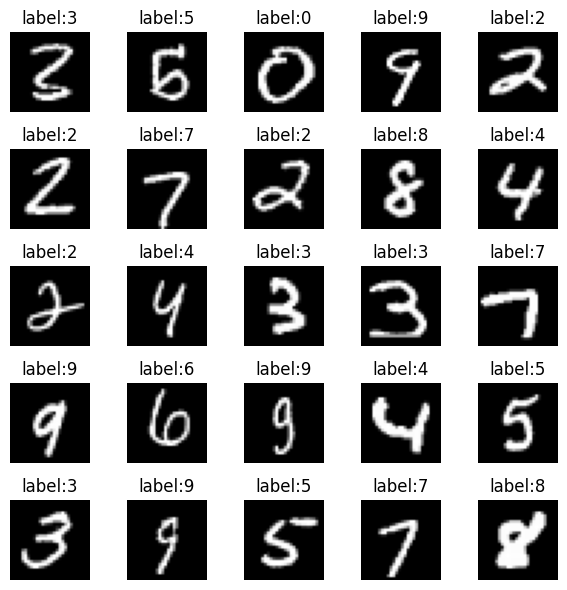

In [7]:
display_images(X_train, y_train)



```
# This is formatted as code
```

You will be making three total models so you should define methods to standardize the models and maintain consistency.

Try changing teh epochs and see how it affects your model

In [8]:
batch_size=84
epochs=5 # Change to 30
verbose=2

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


def create_model(name:str):
    model = Sequential()
    model._name = name
    # input
    model.add(Conv2D(32, (5,5), padding="same", activation='relu', input_shape=(width, height, channels) ))
    model.add(Conv2D(32, (5,5), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(384, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    print(model.summary())
    opt = "adam" #Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [9]:
def plot_metrics(h, title=""):
    """ Plot training metrics - loss and accuracy, for each epoch,
        given a training history object
    """
    fig, axes = plt.subplots(1,2, figsize=(10,5))

    axes[0].plot(h.history['loss'], color="lightblue", label="Training", lw=2.0)
    axes[0].plot(h.history['val_loss'], color="steelblue", label="Validation", lw=2.0)

    axes[0].set_title(f"{title} (Loss)")
    axes[0].set_xlabel("Epoch")
]    axes[0].set_xticks(np.arange(len(h.history["loss"]), 2))
    axes[0].set_ylabel("Loss")

    axes[1].plot(h.history['accuracy'], color="lightblue", label="Training", lw=2.0)
    axes[1].plot(h.history['val_accuracy'], color="steelblue", label="Validation", lw=2.0)

    axes[1].set_title(f"{title} (Accuracy)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_xticks(np.arange(len(h.history["accuracy"]), 2))
    axes[1].set_ylabel("Accuracy")


    for axis in axes:
      axis.ticklabel_format(useOffset=False)
      axis.spines["top"].set_visible(False)
      axis.spines["right"].set_visible(False)
      axis.legend(loc='best', shadow=False)
    fig.tight_layout()

In [10]:
def plot_losses(batch_hist, title=""):
    fig, ax1 = plt.subplots()

    ax1.semilogx(batch_hist.losses)
    ax1.set_title("{} (Batch Loss)".format(title))

    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)

    plt.show()

Create your first model and visualize it:

In [11]:
model0 = create_model(name='cnn_model')

model0_batch_hist = LossHistory()

model0_metrics = model0.fit(
    X_train, y_train, batch_size = batch_size, epochs = epochs,
    validation_data = (X_cv, y_cv), verbose = verbose, shuffle=True, callbacks=[model0_batch_hist])

#model0.save_weights("model0.h5")

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                         

### Learning Rate Annealing

Learning rate is the step size in gradient descent. If the step size is too large, the system may oscillate chaotically. On the other hand, if the step size is too small, it may take too long or may settle on a local minimum.

You will watch validation accuracy in each epoch and reduce the learning rate to a third if it plateaus in two consecutive epochs. Keras provides an aptly named ReduceLROnPlateau callback to adapt the learning rate based on results from each epoch. Ref: ReduceLROnPlateau for more options.

The verbose mode allows you to see when the learning rate reduction actually kicks in.

In [12]:
learning_rate_controller = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=verbose, factor=0.3, min_lr=0.00001, epsilon=0.001)

Create a new instance of the same model, but this time insert a callback to the learning rate control function defined above. Then fit the model to your training dataset and collect metrics.

In [13]:
model1 = create_model(name='cnn_lr_model')
model1_batch_hist = LossHistory()
model1_metrics = model1.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,
          validation_data = (X_cv, y_cv), verbose = verbose, shuffle=True, callbacks=[learning_rate_controller,model1_batch_hist])
#model1.save_weights("model1.h5")

Model: "cnn_lr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

# Data Augmentation
To reduce overfitting and to improve classification accuracy, you can augment the training samples with random transformations of images in the training set. In Keras, this is done using keras.preprocessing.image.ImageDataGenerator class. You can apply random transformations such as zooming, rotation, and shifting the image up or down. You should limit the rotation to a few degrees, and disable horizontal and vertical flipping, as this dataset of digits is prone to produce ambiguous results with these operations.

See ImageDataGenerator for lots of other options that are useful for other types of images.

In [14]:
idg = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=False,
        vertical_flip=False, data_format="channels_last")

Example images are generated:

Sample images from ImageDataGenerator:


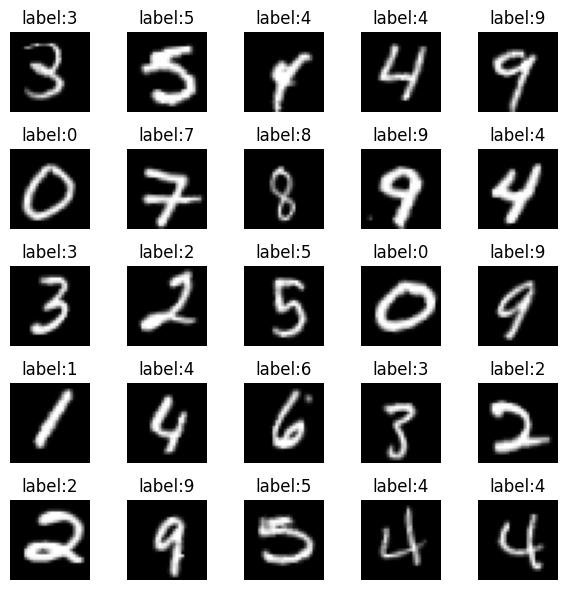

In [15]:
image_data = idg.flow(X_train,y_train, batch_size=25).next()
print("Sample images from ImageDataGenerator:")
display_images(image_data[0], image_data[1])

# New SectionModel with data augmentation
Create yet another instance of the model you defined earlier with the learning rate annealer. This time instead of fitting it to the training dataset, you will instead fit it to the images generated by the ImageDataGenerator. Then collect loss and accuracy metrics for comparison.

In [16]:
model2 = create_model(name='cnn_lr_aug_model')
model2_batch_hist = LossHistory()
model2_metrics = model2.fit_generator(idg.flow(X_train,y_train, batch_size=batch_size),
                    epochs = epochs,
                    steps_per_epoch=X_train.shape[0]//batch_size,
                    validation_data=(X_cv,y_cv),
                    callbacks=[learning_rate_controller,model2_batch_hist],
                    verbose = verbose)
#model2.save_weights("model2.h5")

Model: "cnn_lr_aug_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        36928     
                                                  

<ipython-input-16-63c13a8a757b>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2_metrics = model2.fit_generator(idg.flow(X_train,y_train, batch_size=batch_size),


300/300 - 169s - loss: 0.4623 - accuracy: 0.8468 - val_loss: 0.0729 - val_accuracy: 0.9763 - lr: 0.0010 - 169s/epoch - 565ms/step
Epoch 2/5
300/300 - 175s - loss: 0.1466 - accuracy: 0.9554 - val_loss: 0.0561 - val_accuracy: 0.9826 - lr: 0.0010 - 175s/epoch - 583ms/step
Epoch 3/5
300/300 - 175s - loss: 0.1140 - accuracy: 0.9658 - val_loss: 0.0444 - val_accuracy: 0.9865 - lr: 0.0010 - 175s/epoch - 584ms/step
Epoch 4/5
300/300 - 167s - loss: 0.0975 - accuracy: 0.9707 - val_loss: 0.0386 - val_accuracy: 0.9877 - lr: 0.0010 - 167s/epoch - 557ms/step
Epoch 5/5
300/300 - 167s - loss: 0.0814 - accuracy: 0.9746 - val_loss: 0.0362 - val_accuracy: 0.9890 - lr: 0.0010 - 167s/epoch - 557ms/step


# Comparing the loss functions
A plot of the loss function over all batches shows the effects of learning rate annealing and data augmentation. The learning rate annealer appears to reduce noise.


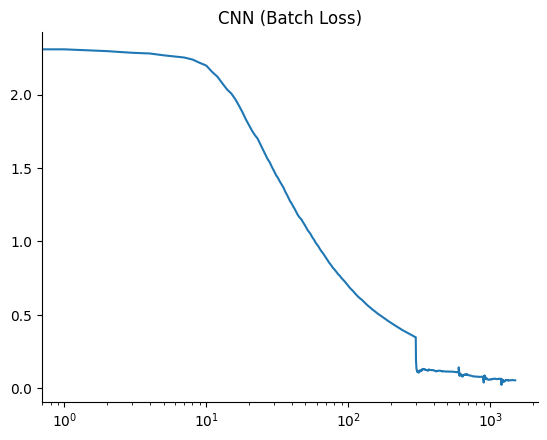

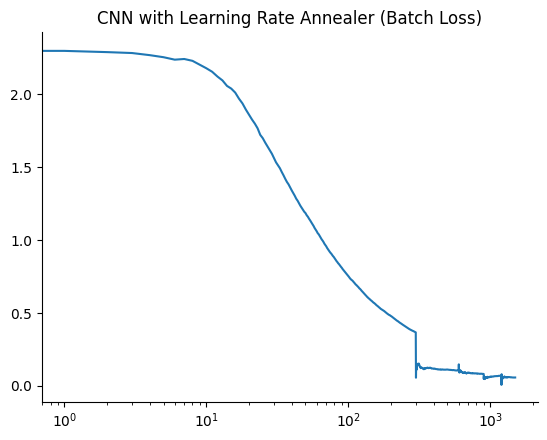

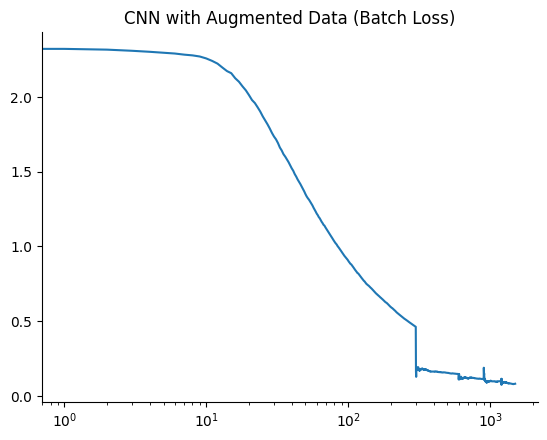

In [17]:
plot_losses(model0_batch_hist, "CNN")
plot_losses(model1_batch_hist, "CNN with Learning Rate Annealer")
plot_losses(model2_batch_hist, "CNN with Augmented Data")

# Results
Keras provides a History callback that returns loss and accuracy metrics for training and validation sets for each epoch. Plots of the loss and accuracy metrics on training and validation data from the three models, help you to see the effects of learning rate annealing and data augmentation.

The learning rate annealer smoothed the loss and accuracy metrics.
Data augmentation reduced overfitting compared to the previous models.

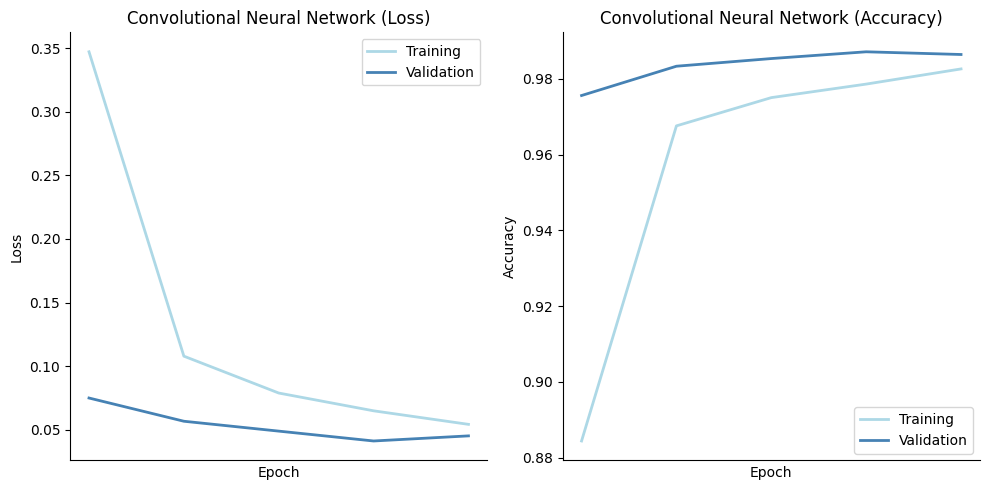

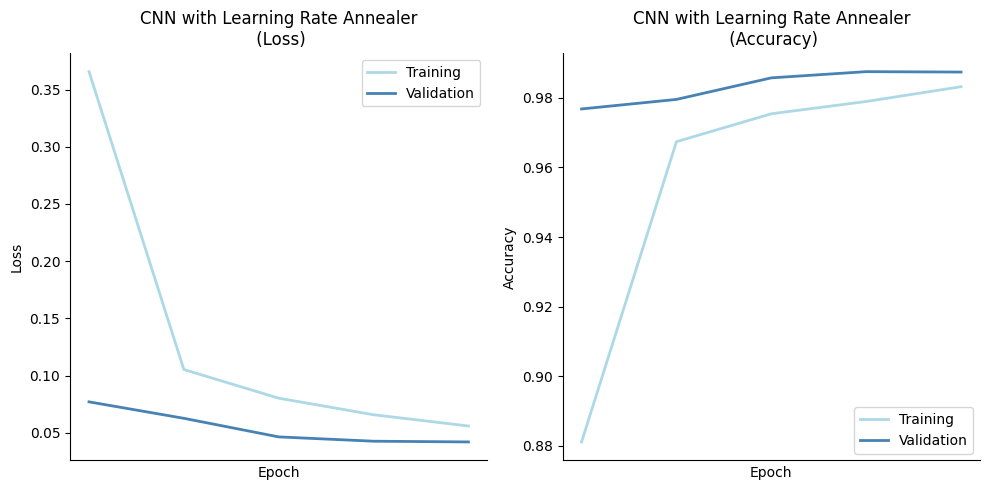

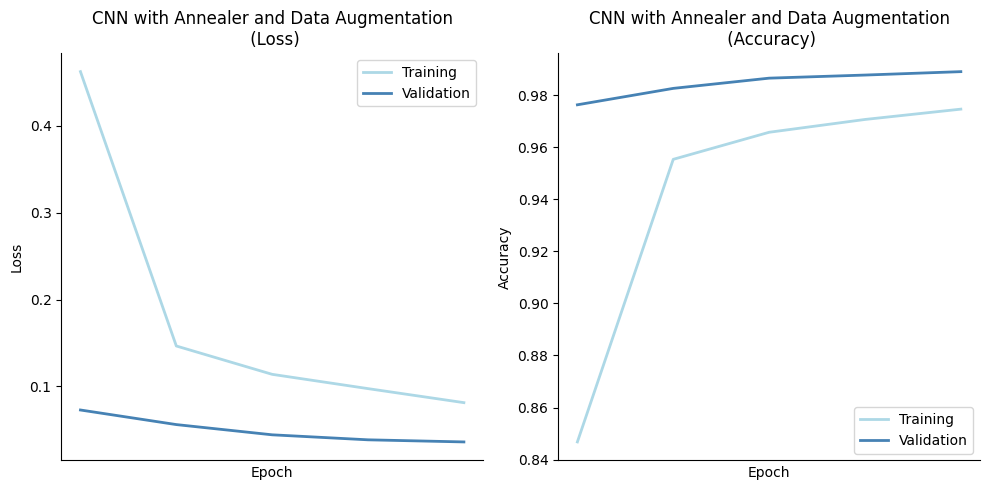

In [18]:
plot_metrics(model0_metrics,"Convolutional Neural Network")
plot_metrics(model1_metrics,"CNN with Learning Rate Annealer\n")
plot_metrics(model2_metrics,"CNN with Annealer and Data Augmentation\n")

# Classification Accuracy
Finally, a summary of how the three models performed in terms of training, validation and test accuracy:

Model,Training Accuracy,Validation Accuracy,Test Accuracy
Convolutional Neural Network,98.26,98.64,98.61
CNN + Learning Rate Annealing,98.32,98.74,98.82
CNN + LR + Data Augmentation,97.46,98.90,98.98


Text(0.5, 1.0, 'Accuracy')

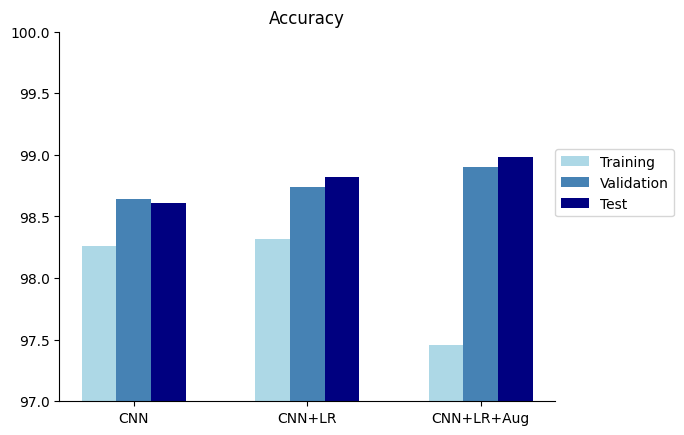

In [20]:
models = [model0, model1, model2]
metrics = [model0_metrics, model1_metrics, model2_metrics]
names = ["Convolutional Neural Network", "CNN + Learning Rate Annealing", "CNN + LR + Data Augmentation"
         ]
data = []
for i, m in enumerate(zip(names, metrics, models)):
    data.append([m[0], "{:0.2f}".format(m[1].history["accuracy"][-1]*100), "{:0.2f}".format(m[1].history["val_accuracy"][-1]*100), "{:0.2f}".format(m[2].evaluate(X_test, y_test, verbose=0)[1]*100)])

results = pd.DataFrame(data, columns=("Model","Training Accuracy","Validation Accuracy", "Test Accuracy"))
from IPython.display import display, HTML
display(HTML(results.to_html(index=False)))
plt.bar(np.arange(len(results["Model"].values)),results["Training Accuracy"].values.astype("float64"), 0.2, color="lightblue")
plt.bar(np.arange(len(results["Model"].values))+0.2,results["Validation Accuracy"].values.astype("float64"), 0.2, color="steelblue")
plt.bar(np.arange(len(results["Model"].values))+0.4,results["Test Accuracy"].values.astype("float64"), 0.2, color="navy")
plt.ylim(97, 100)
plt.xticks(np.arange(len(results["Model"].values))+0.2, ["CNN","CNN+LR", "CNN+LR+Aug"])
plt.legend(["Training","Validation", "Test"],loc=(1,0.5))
g = plt.gca()
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
plt.title("Accuracy")